In [1]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import NeuralTrajectory, SpikeTrain
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

from umap.umap_ import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS
from scipy.optimize import curve_fit

code_id = "0860 - Decoding Retrieval With GNB"
loc = os.path.join(figpath, "Dsp", code_id)
mkdir(loc)

saved_dir = join(loc, "Decoded Results")
dir_name = join(figpath, "Dsp", "Reforming Neural Trajectory Analysis") 
mkdir(saved_dir)
pass

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB is already existed!
        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Decoded Results is already existed!


# Smallest number of neurons for decoding

In [2]:
for i in range(1, len(f_CellReg_dsp)):
    with open(f_CellReg_dsp['cellreg_folder'][i], 'rb') as f:
        index_map = pickle.load(f)
        if f_CellReg_dsp['MiceID'][i] != 10232:
            index_map = index_map[1:, :]
        
        is_cell = np.where(index_map > 0, 1, 0)
        n_cells = np.sum(is_cell, axis=0)
        print(f"{f_CellReg_dsp['MiceID'][i]}: {np.where(n_cells == 7)[0].shape[0]}")

10212: 118
10224: 144
10227: 302
10232: 261


In [2]:
N_MIN = 118-2 # neurons of all mice should downsample to this number.

def identify_SA_SB_separation(trace):
    beg, end = LapSplit(trace, trace['paradigm'])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg, trace['maze_type'])
    droute = np.diff(routes)
    middle_route1_beg = np.where((routes[1:] == 0)&(droute <= -3))[0][0] + 1
    middle_route1_end = np.where((routes[:-1] == 0)&(droute >= 4))[0][0] + 1
    middel_r1_laps = np.arange(middle_route1_beg, middle_route1_end)
    intervals = trace['lap beg time'][middel_r1_laps[1:]] - trace['lap end time'][middel_r1_laps[:-1]]
    idx = np.where(intervals > 99000)[0]
    if idx.shape[0] == 1:
        return middel_r1_laps[idx[0]+1]
    elif idx.shape[0] == 2:
        return middel_r1_laps[idx[1]+1]
        # There should be 9 breakpoints to separate all the laps into 10 groups.
        # 这里主要是两个异常值的处理，仅限于截止至2024年8月1日的10224/27 2023-10-11 session 1
        # (correct session) 中route 1b存在两个lap之间时间超过了99s，从而使得我们上述的判别
        # route 1b 1c之间的breakpoints无法辨别具体的位置。考虑到这两处异常均位于session 1，我们
        # 直接去除所找到的第一个值，保留第二个值作为1b1c的gap。
        # 因此对于任何新的数据，如果两个lap之间的时间间隔超过了99s，并且位于session 2，此处仍会
        # 报错并错误的分类，需注意！
    else:
        raise ValueError("Cannot identify the breakpoint between route 1b and 1c.")


def gnb_decoder(trace, n: int):
    """
    Decode the trace using the GNB decoder.
    """
    print(join(saved_dir, f"{int(trace['MiceID'])}_{n}.pkl"))
    if exists(join(saved_dir, f"{int(trace['MiceID'])}_{n}.pkl")):
        with open(join(saved_dir, f"{int(trace['MiceID'])}_{n}.pkl"), 'rb') as f:
            (
                pos_traj,
                nodes_traj,
                speed_traj,
                smoothed_speed_traj,
                cumlen_traj,
                time_traj,
                lap_traj,
                route_traj,
                perfect_traj,
                raw_traj,
                spike_traj,
                part_traj,
                
                loss_traj,
                loss_shuf_traj,
                smoothed_loss_traj,
                smoothed_loss_shuf_traj,
                decoded_nodes_traj,
                decoded_nodes_traj_shuf,
                retriv_state_traj
            ) = pickle.load(f)
        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0], [len(loss_traj)]))
    else:
        beg, end = LapSplit(trace, trace['paradigm'])
        beg_t, end_t = trace['lap beg time'], trace['lap end time']
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg, trace['maze_type'])
        
        raw_traces = trace['RawTraces']
        spike_traj = []
        ms_time = trace['ms_time']
        spike_nodes = trace['spike_nodes_original']
        
        raw_traj = []
        pos_traj = []
        nodes_traj = []
        cumlen_traj = []
        time_traj = []
        lap_traj = []
        route_traj = []
        speed_traj = []
        perfect_traj = []
        part_traj = []
        session_split_point = identify_SA_SB_separation(trace)
        
        print(f"{trace['MiceID']} Initialization. ----------------- {DateTime()}")
        for i in tqdm(range(len(beg))):
            spike_idx = np.where(
                (ms_time >= beg_t[i]) & (ms_time <= end_t[i]) &
                (np.isnan(trace['spike_nodes_original']) == False)
            )[0]
            ms_t = (ms_time[spike_idx]-ms_time[spike_idx[0]])/1000

            displacement = np.diff(trace['correct_pos'][beg[i]:end[i], :]/10, axis=0)
            dt = np.diff(trace['correct_time'][beg[i]:end[i]])
            speed = np.sqrt(np.sum(displacement**2, axis=1)) * 1000 / dt
            t = (trace['correct_time'][beg[i]:end[i]] - trace['correct_time'][beg[i]])/1000
            cumlen = np.cumsum(np.sqrt(np.sum(displacement**2, axis=1)))
            
            behav_to_ms_idx = _coordinate_recording_time(ms_t.astype(np.float64), t.astype(np.float64))

            pos_traj.append(trace['correct_pos'][beg[i]:end[i], :][behav_to_ms_idx, :].T/10)
            nodes_traj.append(trace['correct_nodes'][beg[i]:end[i]][behav_to_ms_idx])
            speed_traj.append(np.concatenate(([0], speed))[behav_to_ms_idx])
            cumlen_traj.append(np.concatenate(([0], cumlen))[behav_to_ms_idx])
            time_traj.append(ms_t)
            lap_traj.append(np.ones_like(ms_t) * i)
            route_traj.append(np.ones_like(ms_t) * routes[i])
            perfect_traj.append(np.ones_like(ms_t) * trace['is_perfect'][i])
            raw_traj.append(raw_traces[:, spike_idx])
            spike_traj.append(trace['Spikes_original'][:, spike_idx])
            if session_split_point > i:
                part_traj.append(np.repeat(0, ms_t.shape[0]))
            else:
                part_traj.append(np.repeat(1, ms_t.shape[0]))

        pos_traj = np.concatenate(pos_traj, axis=1).astype(np.float64)
        nodes_traj = np.concatenate(nodes_traj).astype(np.int64)
        speed_traj = np.concatenate(speed_traj).astype(np.float64)
        cumlen_traj = np.concatenate(cumlen_traj).astype(np.float64)
        time_traj = np.concatenate(time_traj).astype(np.float64)
        lap_traj = np.concatenate(lap_traj).astype(np.int64)

        route_traj = np.concatenate(route_traj).astype(np.int64)
        perfect_traj = np.concatenate(perfect_traj).astype(np.int64)
        raw_traj = np.concatenate(raw_traj, axis=1).astype(np.float64)
        part_traj = np.concatenate(part_traj).astype(np.int64)
        spike_traj = np.concatenate(spike_traj, axis=1).astype(np.int64)
        Spikes = np.where(raw_traj - np.std(raw_traj, axis=1)[:, np.newaxis] * 3 >= 0, 1, 0)

        D = GetDMatrices(1, 48)
        
        loss_traj = np.zeros((7, Spikes.shape[1]), dtype=np.float64)
        loss_shuf_traj = np.zeros((7, Spikes.shape[1]), dtype=np.float64)
        decoded_nodes_traj = np.zeros((7, Spikes.shape[1]), dtype=np.int64)
        decoded_nodes_traj_shuf = np.zeros((7, Spikes.shape[1]), dtype=np.int64)
        
        print(f"  Decoding Starts:")
        print(DateTime())
        
        if exists(join(saved_dir, f"{int(trace['MiceID'])}_{n}_temp.pkl")):
            with open(join(saved_dir, f"{int(trace['MiceID'])}_{n}_temp.pkl"), 'rb') as f:
                loss_traj, loss_shuf_traj, decoded_nodes_traj, decoded_nodes_traj_shuf, r_i = pickle.load(f)
        else:
            r_i = 0
        
        for rt in range(r_i, 7):
            print(f"      Train R{rt+1}, Test Others.")
            train_idx = np.where(route_traj == rt)[0]
            test_idx = np.arange(Spikes.shape[1])
            model = NaiveBayesDecoder(maze_type=1, res=48, smooth_matrix=trace['Ms'])
            model.fit(Spikes[:, train_idx], nodes_traj[train_idx])
            y_pred = model.predict(Spikes_test=Spikes[:, test_idx], MazeID_test=nodes_traj[test_idx])
            y_test = nodes_traj[test_idx]
            loss_traj[rt, test_idx] = D[(y_pred-1, y_test-1)]
            decoded_nodes_traj[rt, test_idx] = y_pred   
            y_pred_shuf = model.predict(Spikes_test=Spikes[:, test_idx][np.random.permutation(Spikes.shape[0]), :], MazeID_test=nodes_traj[test_idx])
            loss_shuf_traj[rt, test_idx] = D[(y_pred_shuf-1, y_test-1)]
            decoded_nodes_traj_shuf[rt, test_idx] = y_pred_shuf
                
            with open(join(saved_dir, f"{int(trace['MiceID'])}_{n}_temp.pkl"), 'wb') as f:
                pickle.dump((
                    loss_traj,
                    loss_shuf_traj,
                    decoded_nodes_traj,
                    decoded_nodes_traj_shuf,
                    rt+1
                ), f)
            print("\n")
        
        x = np.linspace(-5, 5, 11)
        sigma = 1.0
        gkernel = np.exp(-x**2/(2*sigma**2))
        gkernel /= np.sum(gkernel)
        
        smoothed_loss_traj = np.zeros_like(loss_traj, dtype=np.float64)
        smoothed_loss_shuf_traj = np.zeros_like(loss_shuf_traj, dtype=np.float64)
        smoothed_speed_traj = np.zeros_like(speed_traj, dtype=np.float64)
        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0]+1, [len(lap_traj)]))
        for i in range(len(beg)):
            for rt in range(7):
                smoothed_loss_traj[rt, beg[i]:end[i]] = np.convolve(loss_traj[rt, beg[i]:end[i]], gkernel, mode='same')
                smoothed_loss_shuf_traj[rt, beg[i]:end[i]] = np.convolve(loss_shuf_traj[rt, beg[i]:end[i]], gkernel, mode='same')
            smoothed_speed_traj[beg[i]:end[i]] = np.convolve(speed_traj[beg[i]:end[i]], gkernel, mode='same')
            
    print("Identify Retrieval Moment.")
    retriv_state_traj = np.zeros(lap_traj.shape[0], dtype=np.int64)
    retriv_state_traj[smoothed_loss_traj[0, :] < 10] = 1
    for i in range(len(beg)):
        if route_traj[beg[i]] == 0:
            retriv_state_traj[beg[i]:end[i]] = 1
            continue

        _converge_idx = np.where(smoothed_loss_traj[0, beg[i]:end[i]] <= 10)[0]

        if _converge_idx.shape[0] < 1:
            continue
        
        retriv_state_traj[beg[i]:beg[i] + _converge_idx[0]] = 0
        retriv_state_traj[beg[i] + _converge_idx[0]:end[i]] = 2
        retriv_state_traj[beg[i] + _converge_idx] = 1
    
    with open(join(saved_dir, f"{int(trace['MiceID'])}_{n}.pkl"), 'wb') as f:
        pickle.dump((
            pos_traj,
            nodes_traj,
            speed_traj,
            smoothed_speed_traj,
            cumlen_traj,
            time_traj,
            lap_traj,
            route_traj,
            perfect_traj,
            raw_traj,
            spike_traj,
            part_traj,
            
            loss_traj,
            loss_shuf_traj,
            smoothed_loss_traj,
            smoothed_loss_shuf_traj,
            decoded_nodes_traj,
            decoded_nodes_traj_shuf,
            retriv_state_traj
        ), f)
    
    return (
        pos_traj,
        nodes_traj,
        speed_traj,
        smoothed_speed_traj,
        cumlen_traj,
        time_traj,
        lap_traj,
        route_traj,
        perfect_traj,
        raw_traj,
        spike_traj,
        part_traj,
        
        loss_traj,
        loss_shuf_traj,
        smoothed_loss_traj,
        smoothed_loss_shuf_traj,
        decoded_nodes_traj,
        decoded_nodes_traj_shuf,
        retriv_state_traj
    )


for n in range(24, len(f2)):
    if f2['MiceID'][n] != 10227:
        continue
    
    
    with open(f2['Trace File'][n], 'rb') as f:
        trace = pickle.load(f)
        
    gnb_decoder(trace, n)

D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Decoded Results\10227_25.pkl
10227 Initialization. ----------------- 2025-12-06 03:20:02


100%|██████████| 100/100 [00:00<00:00, 276.24it/s]


  Decoding Starts:
2025-12-06 03:20:04
      Train R1, Test Others.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.452038049697876 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39180/39180 [16:31<00:00, 39.51it/s]


    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.38900303840637207 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39180/39180 [18:25<00:00, 35.45it/s]




      Train R2, Test Others.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.1360008716583252 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39180/39180 [17:22<00:00, 37.58it/s]


    Generating tuning curve
    Tuning curve generation time: 0.1381511688232422 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39180/39180 [19:01<00:00, 34.32it/s]  




      Train R3, Test Others.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.07000446319580078 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39180/39180 [17:16<00:00, 37.82it/s]


    Generating tuning curve
    Tuning curve generation time: 0.07199859619140625 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39180/39180 [19:31<00:00, 33.46it/s]  




      Train R4, Test Others.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06273031234741211 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39180/39180 [15:12<00:00, 42.93it/s]


    Generating tuning curve
    Tuning curve generation time: 0.058348894119262695 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39180/39180 [14:43<00:00, 44.33it/s]




      Train R5, Test Others.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.10652804374694824 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39180/39180 [14:51<00:00, 43.96it/s]


    Generating tuning curve
    Tuning curve generation time: 0.09900355339050293 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39180/39180 [15:53<00:00, 41.08it/s]




      Train R6, Test Others.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.07000207901000977 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39180/39180 [15:06<00:00, 43.20it/s]


    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.23280835151672363 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39180/39180 [17:07<00:00, 38.13it/s]




      Train R7, Test Others.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.06299614906311035 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39180/39180 [15:18<00:00, 42.64it/s]


    Generating tuning curve
    Tuning curve generation time: 0.062001943588256836 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 39180/39180 [17:22<00:00, 37.60it/s]




Identify Retrieval Moment.
D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Decoded Results\10227_27.pkl
10227 Initialization. ----------------- 2025-12-06 07:16:42


100%|██████████| 95/95 [00:00<00:00, 228.14it/s]


  Decoding Starts:
2025-12-06 07:16:43
      Train R1, Test Others.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.4394044876098633 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 36211/36211 [14:56<00:00, 40.39it/s]


    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.41571569442749023 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 36211/36211 [16:01<00:00, 37.67it/s]




      Train R2, Test Others.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08499860763549805 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 36211/36211 [14:21<00:00, 42.03it/s]


    Generating tuning curve
    Tuning curve generation time: 0.08646512031555176 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 36211/36211 [14:32<00:00, 41.51it/s]




      Train R3, Test Others.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.08457660675048828 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 36211/36211 [14:14<00:00, 42.38it/s]


    Generating tuning curve
    Tuning curve generation time: 0.06500005722045898 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 36211/36211 [13:02<00:00, 46.28it/s]




      Train R4, Test Others.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.042997121810913086 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 36211/36211 [12:19<00:00, 48.94it/s]


    Generating tuning curve
    Tuning curve generation time: 0.03900003433227539 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 36211/36211 [12:29<00:00, 48.32it/s]




      Train R5, Test Others.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.08780264854431152 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 36211/36211 [12:26<00:00, 48.49it/s]


    Generating tuning curve
    Tuning curve generation time: 0.07499527931213379 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 36211/36211 [10:27<00:00, 57.72it/s]




      Train R6, Test Others.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve generation time: 0.06699943542480469 s
    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 36211/36211 [10:05<00:00, 59.82it/s]


    Generating tuning curve
    Tuning curve generation time: 0.06345748901367188 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 36211/36211 [09:23<00:00, 64.24it/s]




      Train R7, Test Others.
    Generate D matrix
    D matrix successfully generated!
    Generating tuning curve
    Tuning curve generation time: 0.037998199462890625 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 36211/36211 [08:46<00:00, 68.83it/s]


    Generating tuning curve
    Tuning curve generation time: 0.04400229454040527 s


d:\Software\Anaconda3\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)


    Tuning curve successfully generated!
    Generating P matirx Cython...


100%|██████████| 36211/36211 [11:04<00:00, 54.48it/s]




Identify Retrieval Moment.


# Example Laps

(248448,) (248448,)
63.5


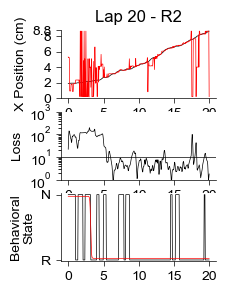

75.5


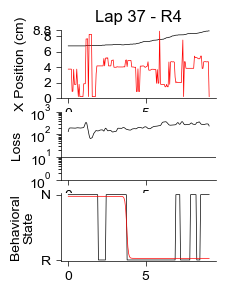

In [5]:
mouse = 10232
with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
    res = pickle.load(f)
    
def logistic_1_to_0(t, t0, k=1.0):
    # optional clipping for numerical safety if T is large
    z = k * (t - t0)
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(z))

def find_best_t0_manual(binary_seq, k=1.0):
    """
    binary_seq: 1D array-like, values in {0, 1}
                1 = non-retrieved, 0 = retrieved
    k: logistic steepness (default = 1)
    
    Returns:
        best_t0: t0 with minimum SSE
        candidate_t0s: array of all tested t0 values
        sse_values: SSE for each candidate t0
    """
    binary_seq = np.asarray(binary_seq, dtype=float)
    T = len(binary_seq)
    t = np.arange(-10, T+10)
    binary_seq_temp = np.concatenate([
        np.ones(10),
        binary_seq,
        np.ones(10)
    ]).astype(np.float64)
    binary_seq_temp = np.convolve(binary_seq_temp, np.ones(5)/5, mode='same')

    # t0 candidates: -0.5, 0.5, ..., T-1.5, T-0.5
    candidate_t0s = np.arange(-0.5, T + 0.5, 1.0)

    sse_values = []
    for t0 in candidate_t0s:
        pred = logistic_1_to_0(t, t0, k=k)
        sse = np.sum((binary_seq_temp - pred) ** 2)
        sse_values.append(sse)

    sse_values = np.array(sse_values)
    best_idx = np.argmin(sse_values)
    best_t0 = candidate_t0s[best_idx]

    return best_t0, candidate_t0s, sse_values
    
pos_traj = res['raw_pos_traj']
nodes_traj = res['raw_nodes_traj']
speed_traj = res['raw_speed_traj']
cumlen_traj = res['raw_cumlen_traj']
time_traj = res['raw_time_traj']
lap_traj = res['raw_lap_traj']
route_traj = res['raw_route_traj']
perfect_traj = res['raw_perfect_traj']
raw_traj = res['raw_traj']
decoded_nodes_traj = res['raw_decoded_nodes_traj'][0, :]
smoothed_loss_traj = res['raw_smoothed_loss_traj'][0, :]
retriv_state_traj = res['raw_retriv_state_traj']
hidden_state_traj = res['raw_hidden_state_traj']
session_traj = res['raw_session_traj']
print(hidden_state_traj.shape, route_traj.shape)

D = GetDMatrices(1, 48)
pred_x = D[decoded_nodes_traj-1, 0] / np.max(D) * 111
test_x = D[nodes_traj-1, 0] / np.max(D) * 111

beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0], [len(lap_traj)]))

for i in range(len(beg)):
    if session_traj[beg[i]] != 0:
        continue
    
    if route_traj[beg[i]] == 0:
        continue
    
    if i not in [19, 36]:
        continue
    
    fig, axes = plt.subplots(3, 1, figsize=(2, 3))
    ax0 = Clear_Axes(axes[0], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax0.plot(time_traj[beg[i]:end[i]], test_x[beg[i]:end[i]], color='black', lw=0.5)
    ax0.plot(time_traj[beg[i]:end[i]], pred_x[beg[i]:end[i]], color='red', lw=0.5)
    ax0.set_ylabel('X Position (cm)')
    ax0.set_title(f"Lap {i+1} - R{route_traj[beg[i]]+1}")
    ax0.set_ylim(0, 110)
    ax0.set_yticks([0, 25, 50, 75, 100, 110], (0, 2, 4, 6, 8, 8.8))
    xlim = ax0.get_xlim()
    ax0.set_xticks(np.linspace(0, 100, 21))
    ax0.set_xlim(xlim[0], xlim[1])
    
    ax1 = Clear_Axes(axes[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax1.plot(time_traj[beg[i]:end[i]], smoothed_loss_traj[beg[i]:end[i]], color='black', lw=0.5)
    ax1.set_ylim(1, 1000)
    ax1.semilogy()
    ax1.axhline(10, color='k', lw=0.5)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Time (s)')
    ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])
    ax1.set_xticks(np.linspace(0, 100, 21))
    ax1.set_xlim(xlim[0], xlim[1])
    
    ax2 = Clear_Axes(axes[2], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    t0 = find_best_t0_manual(hidden_state_traj[beg[i]:end[i]])[0]
    print(t0)
    y = logistic_1_to_0(np.arange(len(hidden_state_traj[beg[i]:end[i]])), t0)
    ax2.plot(time_traj[beg[i]:end[i]], hidden_state_traj[beg[i]:end[i]], color='black', lw=0.5)
    ax2.plot(time_traj[beg[i]:end[i]], y*0.95+0.025, color='red', lw=0.5)
    ax2.set_ylim(-0.02, 1.02)
    ax2.set_yticks(np.linspace(0, 1, 2), ['R', 'N'])
    ax2.set_ylabel('Behavioral\nState')
    ax2.set_xticks(np.linspace(0, 100, 21))
    ax2.set_xlim(xlim[0], xlim[1])
    plt.savefig(join(loc, f"GNB Decoding Lap {i+1} - R{route_traj[beg[i]]+1}.png"), dpi=600)
    plt.savefig(join(loc, f"GNB Decoding Lap {i+1} - R{route_traj[beg[i]]+1}.svg"), dpi=600)
    plt.show()

# Spatial Distribution of Behavioral Retrieval

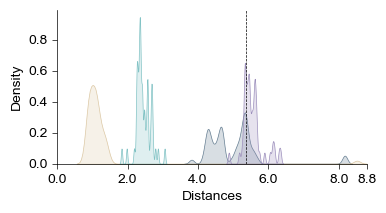

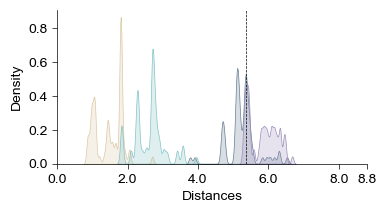

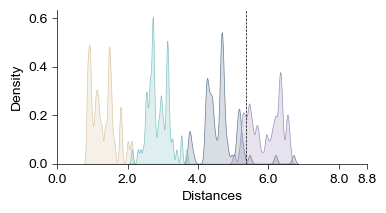

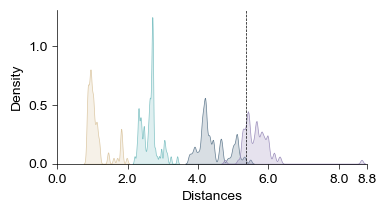

In [4]:
if exists(join(figdata, f"{code_id} [Retrieval Distances].pkl")) == False:
    RetrivDis = {
        "MiceID": [],
        "Session": [],
        "Lap": [],
        "Route": [],
        "Distances": [],
        "Time": [],
        "Type": [],
    }
    D = GetDMatrices(1, 48)
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
            res = pickle.load(f)
    
        hidden_state_traj = res['raw_hidden_state_traj']
        session_traj = res['raw_session_traj']
        lap_traj = res['raw_lap_traj']
        route_traj = res['raw_route_traj']
        pos_traj = res['raw_pos_traj']
        nodes_traj = res['raw_nodes_traj']
        time_traj = res['raw_time_traj']
        smoothed_loss_traj = res['raw_smoothed_loss_traj']

        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0]+1, [len(lap_traj)]))
        print(f"{mouse}:")
        lap_count = 0
        for i in tqdm(range(len(beg))):
            rt = route_traj[beg[i]]
            if rt in [0, 3, 6]:
                continue
            transition_idx = int(find_best_t0_manual(hidden_state_traj[beg[i]:end[i]])[0])+1
            dist = D[nodes_traj[beg[i] + transition_idx]-1, 0]
                
            RetrivDis["MiceID"].append(mouse)
            RetrivDis["Session"].append(session_traj[beg[i]])
            RetrivDis["Lap"].append(lap_count)
            RetrivDis["Route"].append(rt)
            RetrivDis["Distances"].append(dist)
            RetrivDis["Type"].append("Behavioral")
            RetrivDis["Time"].append(time_traj[beg[i] + transition_idx])
                
            # Now for the neural retrieval
            neural_retriv_idx = np.where(smoothed_loss_traj[beg[i]:end[i]] <= 10)[0]
            if neural_retriv_idx.shape[0] < 1:
                neural_retriv_idx = end[i] - beg[i] - 1
            else:
                neural_retriv_idx = neural_retriv_idx[0]
            
            dist_n = D[nodes_traj[beg[i] + neural_retriv_idx]-1, 0]
                
            RetrivDis["MiceID"].append(mouse)
            RetrivDis["Session"].append(session_traj[beg[i]])
            RetrivDis["Lap"].append(lap_count)
            RetrivDis["Route"].append(rt)
            RetrivDis["Distances"].append(dist_n)
            RetrivDis["Type"].append("Neural")
            RetrivDis["Time"].append(time_traj[beg[i] + neural_retriv_idx])
                
            lap_count += 1
    
    for key in RetrivDis.keys():
        if key in ["MiceID", "Session", "Lap", "Route"]:
            RetrivDis[key] = np.array(RetrivDis[key], dtype=np.int64)
        elif key == "Distances":
            RetrivDis[key] = np.array(RetrivDis[key], dtype=np.float64)
        else:
            RetrivDis[key] = np.array(RetrivDis[key])
        
        
    with open(join(figdata, f"{code_id} [Retrieval Distances].pkl"), 'wb') as f:
        pickle.dump(RetrivDis, f)
        
    RetrivDisData = pd.DataFrame(RetrivDis)
    RetrivDisData.to_excel(join(figdata, f"{code_id} [Retrieval Distances].xlsx"), index=False)
    print(len(RetrivDisData))
else:
    with open(join(figdata, f"{code_id} [Retrieval Distances].pkl"), 'rb') as f:
        RetrivDis = pickle.load(f)


RetrivDis['Distances'] = RetrivDis['Distances'] / np.max(GetDMatrices(1, 48) + 1e-8) * 8.8
"""D = GetDMatrices(1, 48)
save_dir = join(loc, "Retrieval Distances")
mkdir(save_dir)
for mouse in [10212, 10224, 10227, 10232]:
    
    nt_idx = np.where((RetrivDis['Type'] == 'Neural') & (RetrivDis['MiceID'] == mouse))[0]
    bt_idx = np.where((RetrivDis['Type'] == 'Behavioral') & (RetrivDis['MiceID'] == mouse))[0]
    fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(2, 7), gridspec_kw={'height_ratios':[1.5, 5.5]})
    ax0 = Clear_Axes(ax[0], close_spines=['top', 'right', 'bottom'], ifxticks=False, ifyticks=True)
    subdata = SubDict(RetrivDis, RetrivDis.keys(), np.where((RetrivDis['Type'] == 'Neural')&(RetrivDis['MiceID'] == mouse))[0])
    sns.histplot(
        x="Distances",
        bins=50,
        hue="Route",
        palette=[DSPPalette[i] for i in [1, 2, 4, 5]],
        line_kws={'linewidth': 0.5},
        stat="density",
        element="step",
        linewidth=0.5,
        data=subdata,
        ax=ax0,
        legend=False
    )
    for dp in DP_DSPs[1][0]:
        sonbins = np.array(Father2SonGraph[dp])
        dp_dists = D[sonbins-1, 0] / np.max(D+1e-8) * 8.8
        dmin, dmax = np.min(dp_dists), np.max(dp_dists)
        ax0.fill_betweenx(
            y=[0, 1.2],
            x1=dmin,
            x2=dmax,
            alpha=0.2,
            color='k',
            edgecolor=None
        )
    ax0.set_xlim(0, 8.8)
    ax1 = Clear_Axes(ax[1], close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax1.scatter(
        RetrivDis['Distances'][nt_idx],
        RetrivDis['Lap'][nt_idx],
        c="#b7c9e6",
        s=8,
        linewidths=0.1,
        edgecolors='k'
    )
    ax1.scatter(
        RetrivDis['Distances'][bt_idx],
        RetrivDis['Lap'][bt_idx],
        c="#f1c6a7",
        s=8,
        linewidths=0.1,
        edgecolors='k'
    )
    for i in range(len(nt_idx)):
        ax1.plot(
            [RetrivDis['Distances'][nt_idx[i]], RetrivDis['Distances'][bt_idx[i]]],
            [RetrivDis['Lap'][nt_idx[i]], RetrivDis['Lap'][bt_idx[i]]],
            color='gray',
            lw=0.1,
            zorder=0
        )
    ax1.set_xlim(0, 8.8)
    plt.show()
"""
for mouse in [10212, 10224, 10227, 10232]:
    fig = plt.figure(figsize=(4, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.kdeplot(
        x="Distances",
        #bins=20,
        hue="Route",
        palette=[DSPPalette[i] for i in [1, 2, 4, 5]],
        #line_kws={'linewidth': 0.5},
        fill=True,
        bw_adjust=0.2,
        #stat="density",
        #element="step",
        linewidth=0.5,
        data=SubDict(RetrivDis, RetrivDis.keys(), np.where(
            (RetrivDis['Type'] == 'Neural') & (RetrivDis['MiceID'] == mouse)
        )[0]),
        ax=ax,
        legend=False
    )
    ax.set_xlim(0, 8.8)
    ax.axvline(5.35, color='k', lw=0.5, ls='--')
    ax.set_xticks(np.append(np.linspace(0, 8, 5), 8.8))
    

# Lap-wise Loss Map Along the Track

        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Loss Maps is already existed!
        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Pretest GNB is already existed!
(192914,) (10, 143640) (118, 94510)
10212:


100%|██████████| 549/549 [00:00<00:00, 24946.89it/s]


10212 (Pretest):


100%|██████████| 180/180 [00:00<00:00, 13838.27it/s]


(236629,) (10, 176107) (144, 115976)
10224:


100%|██████████| 666/666 [00:00<00:00, 24104.57it/s]


10224 (Pretest):


100%|██████████| 281/281 [00:00<00:00, 18727.25it/s]


(281383,) (10, 209833) (302, 138490)
10227:


100%|██████████| 619/619 [00:00<00:00, 21019.91it/s]


10227 (Pretest):


100%|██████████| 241/241 [00:00<00:00, 13034.35it/s]


(248448,) (10, 184862) (261, 121487)
10232:


100%|██████████| 776/776 [00:00<00:00, 22706.24it/s]


10232 (Pretest):


100%|██████████| 382/382 [00:00<00:00, 19727.21it/s]
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:147: RuntimeWarning: divide by zero encountered in log10
  im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)


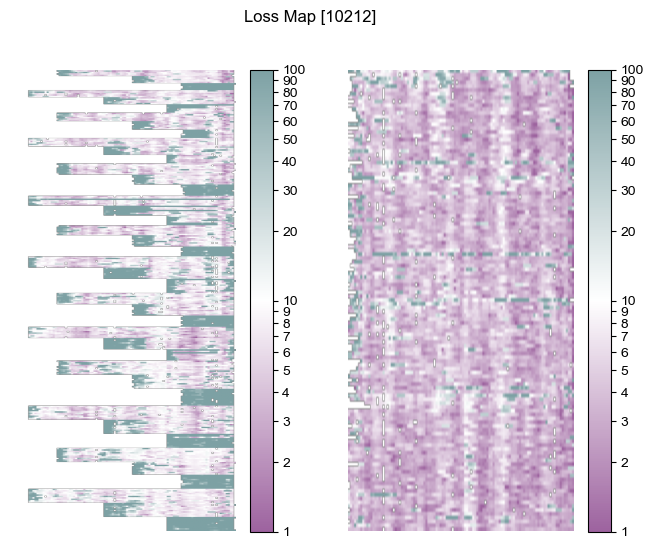

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:167: RuntimeWarning: divide by zero encountered in log10
  (np.clip(np.log10(loss_map), 0, 2))*20,


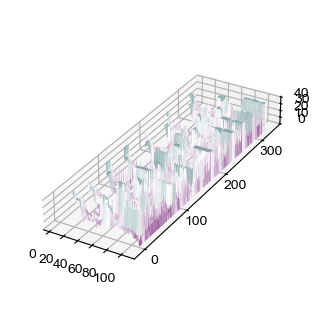

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:185: RuntimeWarning: divide by zero encountered in log10
  diff_map = np.diff(np.log10(loss_map), axis=1)
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:189: RuntimeWarning: divide by zero encountered in log10
  data = np.vstack([np.log10(loss_map)[:, :-1].flatten(), diff_map.flatten()]).T


Saddle point at x = 1.392943576447808, p(x) = 0.07346367613323519


C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:307: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(


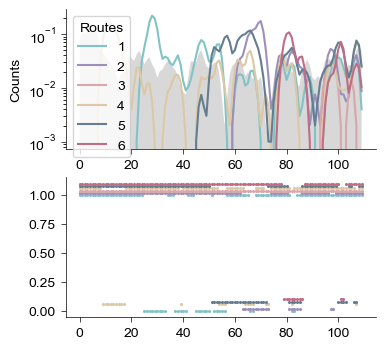

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:147: RuntimeWarning: divide by zero encountered in log10
  im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)


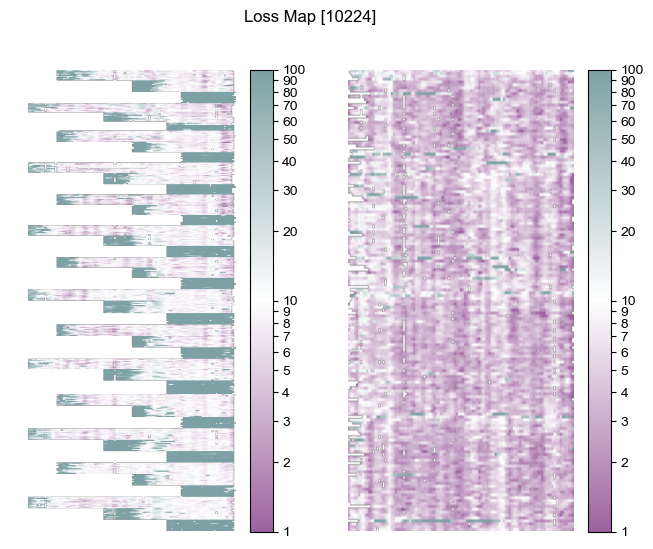

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:167: RuntimeWarning: divide by zero encountered in log10
  (np.clip(np.log10(loss_map), 0, 2))*20,


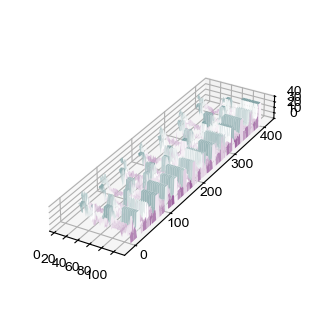

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:185: RuntimeWarning: divide by zero encountered in log10
  diff_map = np.diff(np.log10(loss_map), axis=1)
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:189: RuntimeWarning: divide by zero encountered in log10
  data = np.vstack([np.log10(loss_map)[:, :-1].flatten(), diff_map.flatten()]).T


Saddle point at x = 1.4880335665958135, p(x) = 0.030543065153780517


C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:307: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(


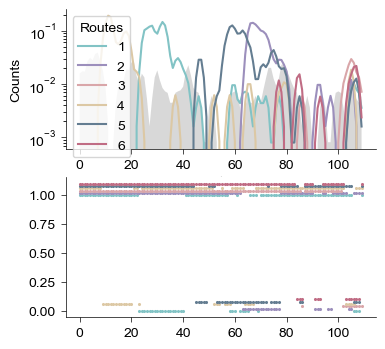

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:147: RuntimeWarning: divide by zero encountered in log10
  im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)


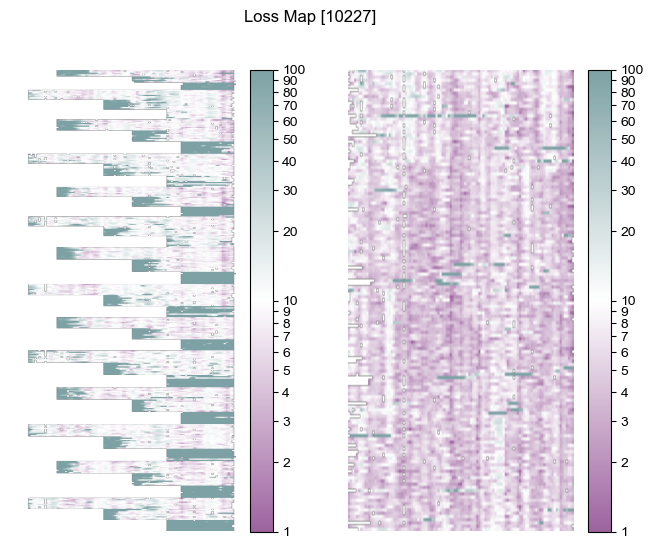

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:167: RuntimeWarning: divide by zero encountered in log10
  (np.clip(np.log10(loss_map), 0, 2))*20,


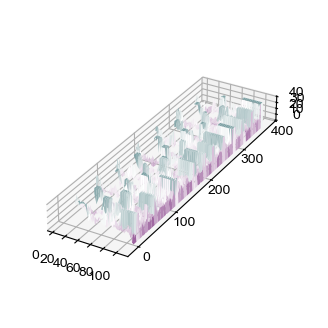

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:185: RuntimeWarning: divide by zero encountered in log10
  diff_map = np.diff(np.log10(loss_map), axis=1)
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:189: RuntimeWarning: divide by zero encountered in log10
  data = np.vstack([np.log10(loss_map)[:, :-1].flatten(), diff_map.flatten()]).T


Saddle point at x = 1.5482991859709072, p(x) = 0.030430548968954238


C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:307: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(


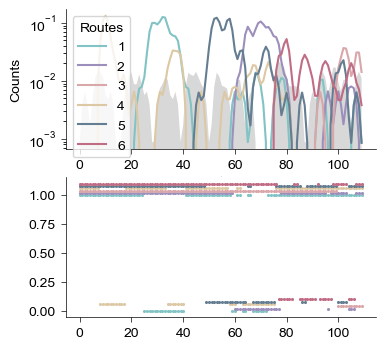

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:147: RuntimeWarning: divide by zero encountered in log10
  im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)


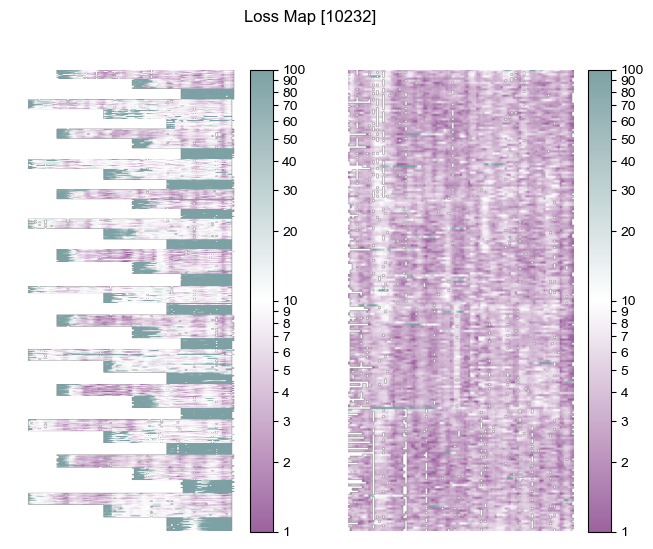

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:167: RuntimeWarning: divide by zero encountered in log10
  (np.clip(np.log10(loss_map), 0, 2))*20,


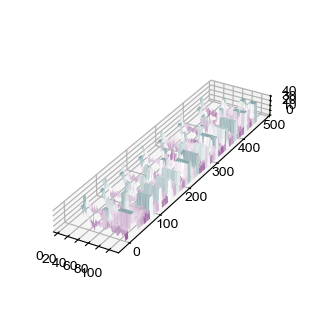

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:185: RuntimeWarning: divide by zero encountered in log10
  diff_map = np.diff(np.log10(loss_map), axis=1)
C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:189: RuntimeWarning: divide by zero encountered in log10
  data = np.vstack([np.log10(loss_map)[:, :-1].flatten(), diff_map.flatten()]).T


Saddle point at x = 1.518362239547164, p(x) = 0.03052323091770784


C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_28996\4104358870.py:307: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.lineplot(


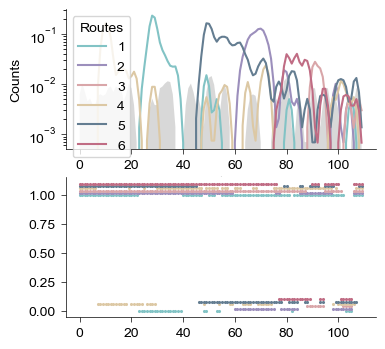

In [ ]:
saved_dir_lossmap = join(loc, "Loss Maps")
mkdir(saved_dir_lossmap)

pretest_gnb_res_dir = join(loc, "Pretest GNB")
mkdir(pretest_gnb_res_dir)
if exists(join(saved_dir_lossmap, f" {10212} [Loss Map].pkl")) == False:
    for mouse in [10212, 10224, 10227, 10232]:
        with open(join(dir_name, f"{mouse}.pkl"), 'rb') as f:
            res = pickle.load(f)
        
        nodes_traj = res['raw_nodes_traj']
        father_nodes_traj = S2F[nodes_traj - 1]
        behav_params_templ_traj = res['behav_params_templ_traj']
        behav_to_raw_traj = res['behav_to_raw_traj']
        behav_params_traj = res['behav_params_traj']
        raw_params_traj = behav_params_traj[:, behav_to_raw_traj]
        print(behav_to_raw_traj.shape, res['behav_params_traj'].shape, res['neural_traj'].shape)
        raw_params_templ_traj = behav_params_templ_traj[:, behav_to_raw_traj]

        behav_res_angles = raw_params_traj[4, :] - raw_params_templ_traj[2, :]
        behav_res_angles[behav_res_angles > np.pi] = 2*np.pi - behav_res_angles[behav_res_angles > np.pi]
        behav_res_angles[behav_res_angles < -np.pi] = -2*np.pi - behav_res_angles[behav_res_angles < -np.pi]

        idx = np.where((np.isin(father_nodes_traj, CP_DSPs[1][0])) & (np.abs(behav_res_angles) <= np.pi/4))[0]

        session_traj = res['raw_session_traj'][idx]
        lap_traj = res['raw_lap_traj'][idx]
        route_traj = res['raw_route_traj'][idx]

        time_traj = res['raw_time_traj'][idx]
        smoothed_loss_traj = res['raw_smoothed_loss_traj'][idx]
        speed_traj = res['raw_speed_traj'][idx]
        raw_traj = res['raw_traj'][:, idx]
        nodes_traj = res['raw_nodes_traj'][idx]
        father_nodes_traj = S2F[nodes_traj - 1]

        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0]+1, [len(lap_traj)]))
        print(f"{mouse}:")
        loss_map = []
        routes = []
        for i in tqdm(range(len(beg))):
            rt = route_traj[beg[i]]
            if rt in [0]:
                continue
            
            lmap = np.zeros(144, np.float64) * np.nan
            for j in range(beg[i], end[i]):
                if speed_traj[j] < 2.5:
                    continue
                lmap[father_nodes_traj[j]-1] = smoothed_loss_traj[j]
            loss_map.append(lmap)
            routes.append(rt)
        
        loss_map = np.vstack(loss_map)[:, CP_DSPs[1][0]-1]
        routes = np.array(routes, dtype=np.int64)
        
        with open(join(saved_dir_lossmap, f"{mouse} [Loss Map].pkl"), 'wb') as f:
            pickle.dump([loss_map, routes], f)
            
        with open(join(pretest_gnb_res_dir, f"{mouse}.pkl"), 'rb') as f:
            pretest_res = pickle.load(f)
            
        loss_traj = pretest_res['loss_traj']
        smoothed_loss_traj = pretest_res['smoothed_loss_traj']
        session_traj = pretest_res['session_traj']
        nodes_traj = pretest_res['nodes_traj']
        father_nodes_traj = S2F[nodes_traj - 1]
        lap_traj = pretest_res['lap_traj']
        time_traj = pretest_res['time_traj']
        route_traj = np.repeat(0, len(lap_traj))
        
        beg = np.concatenate(([0], np.where(np.diff(lap_traj) != 0)[0] + 1))
        end = np.concatenate((np.where(np.diff(lap_traj) != 0)[0]+1, [len(lap_traj)]))
        print(f"{mouse} (Pretest):")
        loss_map = []
        routes = []
        for i in tqdm(range(len(beg))):
            rt = route_traj[beg[i]]
            if session_traj[beg[i]] <9:
                continue
            if rt in [0]:
                lmap = np.zeros(144, np.float64) * np.nan
                for j in range(beg[i], end[i]):
                    lmap[father_nodes_traj[j]-1] = smoothed_loss_traj[j]
                loss_map.append(lmap)
                routes.append(rt)
        loss_map = np.vstack(loss_map)[:, CP_DSPs[1][0]-1]
        routes = np.array(routes, dtype=np.int64)
        with open(join(saved_dir_lossmap, f"{mouse} [Loss Map Pretest].pkl"), 'wb') as f:
            pickle.dump([loss_map, routes], f)

from scipy.optimize import minimize_scalar

def gmm_pdf_scalar(x, weights, means, sigmas):
    # x is scalar
    val = 0.0
    for w, m, s in zip(weights, means, sigmas):
        val += w * (1.0 / (np.sqrt(2 * np.pi) * s)) * np.exp(-0.5 * ((x - m) / s)**2)
    return val
    
def find_gmm_saddle(weights, means, sigmas):
    """
    Find the local minimum of the 2-component GMM pdf between the two means.
    """
    # ensure sorted means
    order = np.argsort(means)
    means = means[order]
    sigmas = sigmas[order]
    weights = weights[order]

    # Minimize p(x) between the two component centers
    res = minimize_scalar(
        lambda z: gmm_pdf_scalar(z, weights, means, sigmas),
        bounds=(means[0], means[1]),
        method='bounded'
    )

    x_saddle = res.x
    y_saddle = gmm_pdf_scalar(x_saddle, weights, means, sigmas)
    return x_saddle, y_saddle

def fit_two_component_gmm(data):
    """
    data: 1D array-like of samples
    returns: fitted GaussianMixture instance
    """
    data = np.asarray(data).reshape(-1, 1)  # GMM expects 2D array

    gmm = GaussianMixture(
        n_components=2,
        covariance_type='full',   # fine for 1D
        random_state=0
    )
    gmm.fit(data)
    return gmm

for mouse in [10212, 10224, 10227, 10232]:
    with open(join(saved_dir_lossmap, f"{mouse} [Loss Map].pkl"), 'rb') as f:
        loss_map, routes = pickle.load(f)

    with open(join(saved_dir_lossmap, f"{mouse} [Loss Map Pretest].pkl"), 'rb') as f:
        loss_map_pretest, routes_pretest = pickle.load(f)
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 6))
    ax0 = Clear_Axes(axes[0])
    im = ax0.imshow(np.log10(loss_map), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)
    cbar = plt.colorbar(im, ax=ax0)
    cbar.set_ticks(np.log10(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])), 
                   labels=np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]))
    ax1 = Clear_Axes(axes[1])
    im = ax1.imshow(np.log10(loss_map_pretest), aspect='auto', cmap=RetrievCmap, vmin=0, vmax=2)
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_ticks(np.log10(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])), 
                   labels=np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]))
    plt.suptitle(f"Loss Map [{mouse}]")
    plt.savefig(join(saved_dir, f"Loss Map [{mouse}].png"), dpi=600)
    plt.savefig(join(saved_dir, f"Loss Map [{mouse}].svg"), dpi=600)
    plt.show()
    
    X, Y = np.meshgrid(np.arange(loss_map.shape[1]), np.arange(loss_map.shape[0]))
    fig = plt.figure(figsize=(4, 4))
    ax = plt.subplot(111, projection='3d')
    ax.plot_surface(
        X,
        Y,
        (np.clip(np.log10(loss_map), 0, 2))*20,
        cmap=RetrievCmap
    )
    ax.set_aspect("equal")
    plt.savefig(join(saved_dir, f"Loss Map 3D [{mouse}].png"), dpi=600)
    plt.savefig(join(saved_dir, f"Loss Map 3D [{mouse}].svg"), dpi=600)
    plt.show()
    """
    x = np.tile(np.arange(loss_map.shape[1]), (loss_map.shape[0], 1))
    fig = plt.figure(figsize=(4, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    sns.lineplot(
        x=x.flatten(),
        y=np.log10(loss_map).flatten(),
        
    )
    plt.show()
    """
    diff_map = np.diff(np.log10(loss_map), axis=1)
    x = np.tile(np.arange(loss_map.shape[1]-1), (loss_map.shape[0], 1))
    rts = np.tile(routes[:, np.newaxis], (1, loss_map.shape[1]-1))

    data = np.vstack([np.log10(loss_map)[:, :-1].flatten(), diff_map.flatten()]).T
    x = x.flatten()
    rts = rts.flatten()
    
    idx = np.where(
        (np.isnan(data).sum(axis=1) == 0) &
        (np.isneginf(data).sum(axis=1) == 0)
    )[0]
    data = data[idx, :]
    x = x[idx]
    rts = rts[idx]
    from sklearn.mixture import GaussianMixture
    
    gmm = fit_two_component_gmm(data[:, 0])
    means = gmm.means_.flatten()        # shape (2,)
    covs = gmm.covariances_.flatten()   # shape (2,) for 1D
    weights = gmm.weights_.flatten()    # shape (2,)
    sigmas = np.sqrt(covs)

    # Sort components by mean so we know "left" and "right"
    order = np.argsort(means)
    means = means[order]
    sigmas = sigmas[order]
    weights = weights[order]
    
    x_saddle, y_saddle = find_gmm_saddle(weights, means, sigmas)
    print(f"Saddle point at x = {x_saddle}, p(x) = {y_saddle}")
    thre = 0.25
    
    data_pretest = np.vstack([
        np.log10(loss_map_pretest)[:, :-1].flatten(),
        np.diff(np.log10(loss_map_pretest), axis=1).flatten()
    ])
    x_pretest = np.tile(
        np.arange(loss_map_pretest.shape[1]-1),
        (loss_map_pretest.shape[0], 1)
    ).flatten()
    """
    plt.figure(figsize=(4, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax.hist(data[:, 0], bins=250, density=True, alpha=0.5, color='gray', range=(0, 2.5))
    ax.axvline(x_saddle, color='red', lw=0.5, ls='--')
    ax.set_title(10**x_saddle)
    plt.show()
    
    plt.figure(figsize=(4, 4))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax.scatter(
        data[:, 0],
        data[:, 1],
        color='gray',
        s=1,
        alpha=0.5
    )
    
    ax.plot([0, 2.5], [x_saddle, x_saddle-2.5], color='k', lw=0.5, ls='--')
    ax.axvline(x_saddle, color='k', lw=0.5, ls='--')
    ax.plot([x_saddle-thre, x_saddle], [thre, thre], color='k', lw=0.5, ls='--')
    ax.plot([x_saddle, x_saddle+thre], [-thre, -thre], color='k', lw=0.5, ls='--')
    plt.show()
    """



# GNB Decoding on pretest data.

In [31]:
pretest_gnb_res_dir = join(loc, "Pretest GNB")
mkdir(pretest_gnb_res_dir)
def get_lapwise_nb_loss_pretest(mouse: int):
    if mouse in [10212]:
        file_idx = np.where(
            (f1['MiceID'] == mouse) &
            (f1['maze_type'] == 1) &
            (f1['Stage'] == 'Stage 1')
        )[0]
        print(len(file_idx))
    elif mouse in [10224, 10227, 10232]:
        file_idx = np.where(
            (f1['MiceID'] == mouse) &
            (f1['maze_type'] == 1) &
            (f1['Stage'] == 'Stage 2')
        )[0]
        print(len(file_idx))
    else:
        raise NotImplementedError(f"Mouse {mouse} not in the pretest group.")
    
    res = {
        "loss_traj": [],
        "smoothed_loss_traj": [],
        "session_traj": [],
        "nodes_traj": [],
        "time_traj": [],
        "lap_traj": [],
    }
    D = GetDMatrices(1, 48)
    for i in range(6, len(file_idx)):
        with open(f1['Trace File'][file_idx[i]], 'rb') as ff:
            trace = pickle.load(ff)
            
        print(f"{trace['MiceID']} ------ S{i+1} ------")
        print(DateTime())
        print(trace.keys())
            
        idx = np.where(
            np.isin(trace['ms_time'], trace['ms_time_behav'])
        )[0]
        
        assert idx.shape[0] == trace['ms_time_behav'].shape[0], "Mismatch in time indices."
        
        RawSpikes = np.where(
            trace['RawTraces'] - np.std(trace['RawTraces'], axis=1, keepdims=True)*3 >= 0, 1, 0
        )
        RawSpikes = RawSpikes[:, idx]
        spike_nodes = trace['spike_nodes_original'][idx].astype(np.int64)
        ms_time_behav = trace['ms_time_behav']
        
        
        lap_beg_time, lap_end_time = trace['lap beg time'], trace['lap end time']
        for j in range(len(lap_beg_time)):
            print(f"   Lap {j+1}:")
            train_idx = np.where(
                (ms_time_behav < lap_beg_time[j]) | 
                (ms_time_behav > lap_end_time[j])
            )[0]
            test_idx = np.where(
                (ms_time_behav >= lap_beg_time[j]) & 
                (ms_time_behav <= lap_end_time[j])
            )[0]
            
            model = NaiveBayesDecoder(maze_type=1, res=48, smooth_matrix=trace['Ms'])
            model.fit(RawSpikes[:, train_idx], spike_nodes[train_idx])
            y_pred = model.predict(Spikes_test=RawSpikes[:, test_idx], MazeID_test=spike_nodes[test_idx]).astype(np.int64)
            y_test = spike_nodes[test_idx].astype(np.int64)
            loss_traj = D[(y_pred-1, y_test-1)]
            smoothed_loss_traj = np.convolve(loss_traj, np.ones(10)/10, mode='same')
            res['loss_traj'].append(loss_traj)
            res['smoothed_loss_traj'].append(smoothed_loss_traj)
            res['session_traj'].append(np.ones_like(loss_traj, dtype=np.int64) * i)
            res['nodes_traj'].append(y_test)
            res['time_traj'].append(ms_time_behav[test_idx])
            res['lap_traj'].append(np.ones_like(loss_traj, dtype=np.int64) * (j+1))
            
    for key in res.keys():
        res[key] = np.concatenate(res[key])
        
    with open(join(pretest_gnb_res_dir, f"{mouse}.pkl"), 'wb') as f:
        pickle.dump(res, f)
    
    print(DateTime())
    print("Saved ---------", end="\n\n\n")
    
#get_lapwise_nb_loss_pretest(10212)
#get_lapwise_nb_loss_pretest(10224)
#get_lapwise_nb_loss_pretest(10227)
#get_lapwise_nb_loss_pretest(10232)

        D:\Data\FinalResults\Dsp\0860 - Decoding Retrieval With GNB\Pretest GNB is already existed!


# Map Cluster for each bin

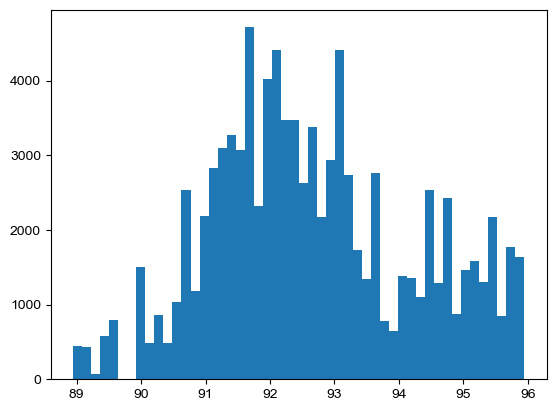

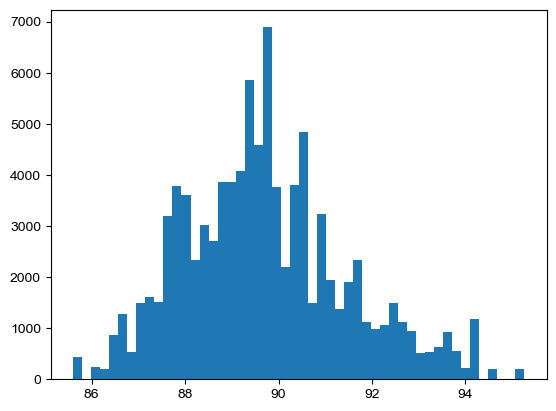

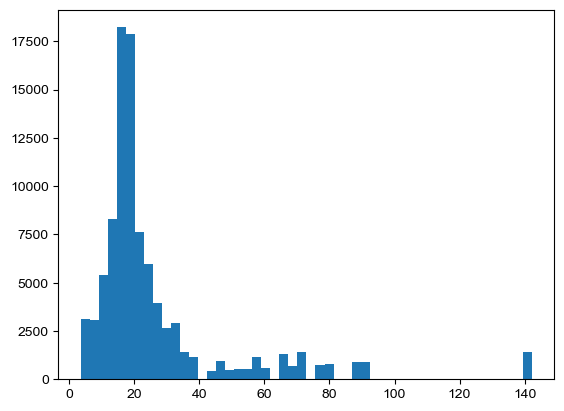

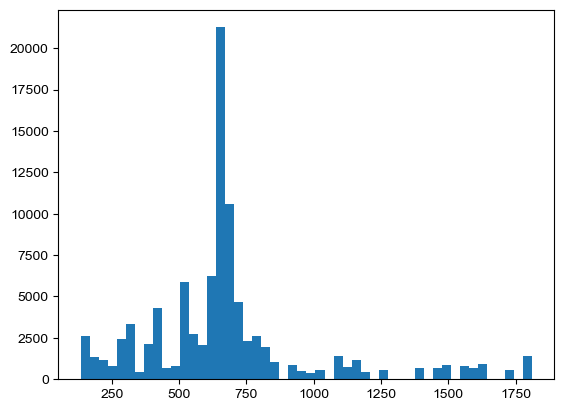

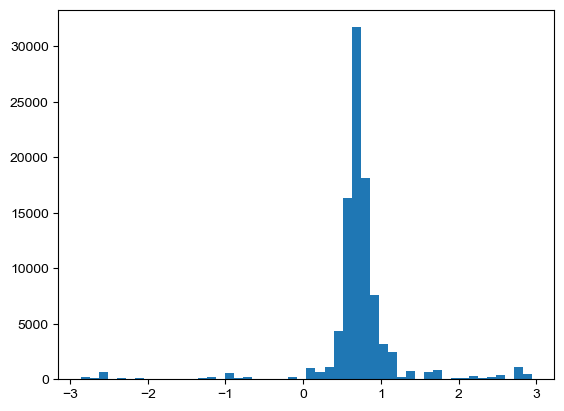

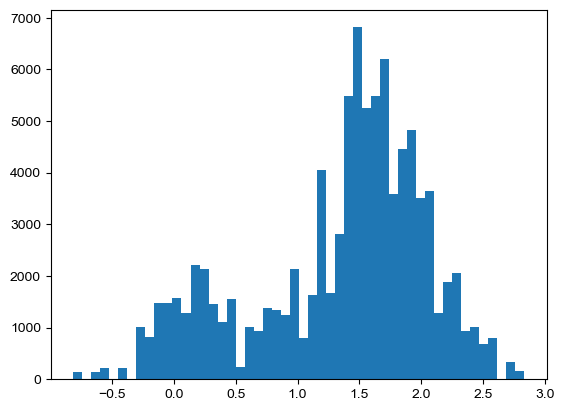

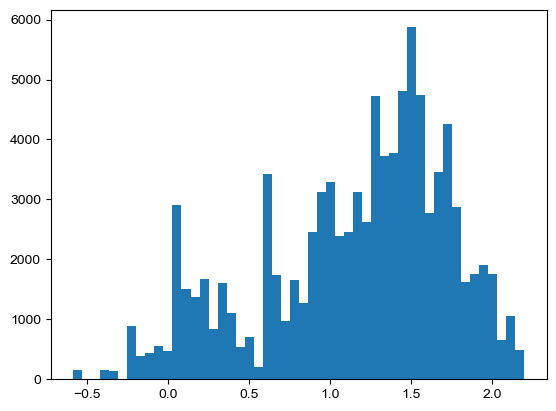

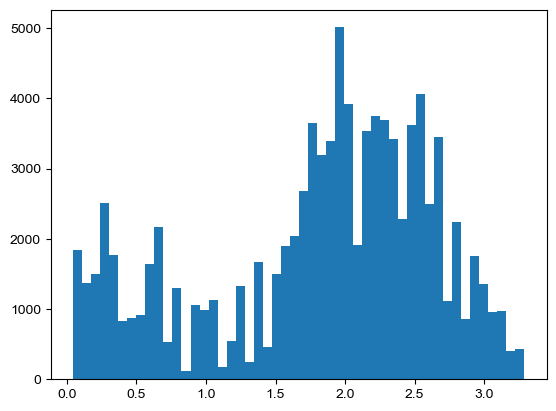

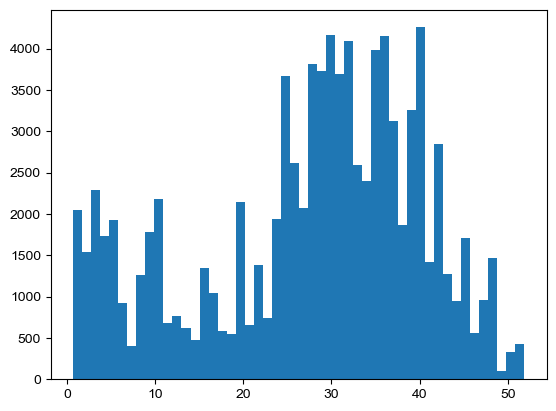

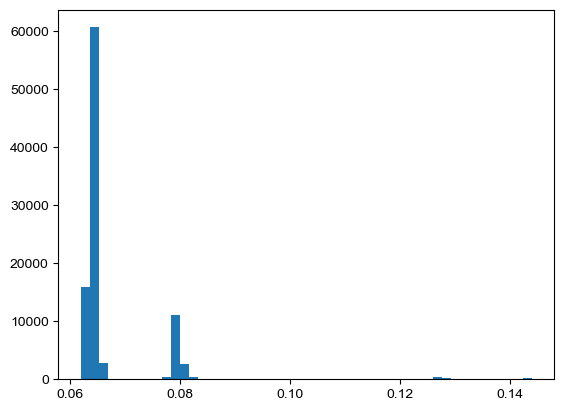

In [ ]:
with open(join(dir_name, f"{10212}.pkl"), 'rb') as f:
    res = pickle.load(f)
    


nodes_traj = res['raw_nodes_traj']
father_nodes_traj = S2F[nodes_traj - 1]
behav_params_templ_traj = res['behav_params_templ_traj']
behav_to_raw_traj = res['behav_to_raw_traj']
behav_params_traj = res['behav_params_traj']
raw_params_traj = behav_params_traj[:, behav_to_raw_traj]
raw_params_templ_traj = behav_params_templ_traj[:, behav_to_raw_traj]

behav_res_angles = raw_params_traj[4, :] - raw_params_templ_traj[2, :]
behav_res_angles[behav_res_angles > np.pi] = 2*np.pi - behav_res_angles[behav_res_angles > np.pi]
behav_res_angles[behav_res_angles < -np.pi] = -2*np.pi - behav_res_angles[behav_res_angles < -np.pi]

idx = np.where((np.isin(father_nodes_traj, CP_DSPs[1][0])) & (np.abs(behav_res_angles) <= np.pi/4))[0]

session_traj = res['raw_session_traj'][idx]
lap_traj = res['raw_lap_traj'][idx]
route_traj = res['raw_route_traj'][idx]

time_traj = res['raw_time_traj'][idx]
smoothed_loss_traj = res['raw_smoothed_loss_traj'][idx]
speed_traj = res['raw_speed_traj'][idx]
raw_traj = res['raw_traj'][:, idx]
nodes_traj = res['raw_nodes_traj'][idx]
father_nodes_traj = S2F[nodes_traj - 1]

